In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import keras
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
(keras.__version__, tf.__version__)

Using TensorFlow backend.


('2.2.2', '1.10.1')

In [4]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv", index_col=['timestamp'])
df.head()

,open,high,low,close,volume
timestamp,,,,,
2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [5]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [6]:
df.shape

(532498, 5)

In [11]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
#cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['open', 'high', 'low', 'close', 'volume']]
#cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
#cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, facecolor='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

KeyError: "['timestamp'] not in index"

In [12]:
n_df = df.copy()
mean = n_df[:200000].mean(axis=0)
n_df -= mean
std = n_df[:200000].std(axis=0)
n_df /= std

In [13]:
# Add a minute moving average over period
def add_moving_avg(df, period=32):
    #df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)
    df[f"{period}_ma"] = df.close.rolling(period).mean()

In [14]:
# add_moving_avg(n_df)
# n_df.tail()

In [15]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        

In [24]:
lookback = 60 * 24 * 5  # Observations will go back a day
step = 6  # Observations will be sampled at one data point per hour
delay = 60 * 24  # Targets will be in 24 hours in the future
batch_size = 128

train_gen = generator(df,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(df,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(df,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)

test_steps = (len(df) - 300001 - lookback)

In [25]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

KeyError: range(287428, 294628, 6)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, GRU, Dropout
from keras.optimizers import Adam

In [15]:
model = Sequential()

model.add(GRU(256,
                input_shape=(6, 64),
                dropout=0.1,
                recurrent_dropout=0.5,
                #return_sequences=True,
                #stateful=False,
             ))
# model.add(GRU(128,
#                 dropout=0.1,
#                 recurrent_dropout=0.5,
#                 return_sequences=True,
#              ))
# model.add(GRU(128,
#                 dropout=0.1,
#                 recurrent_dropout=0.5,
#              ))
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(3, kernel_initializer='lecun_uniform', activation='linear'))
#model.add(Activation('linear')) #linear output so we can have range of real-valued outputs
#model.add(Dense(env.n_actions, activation='linear'))

# model.add(Flatten(input_shape=env.observation_space.shape))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(env.n_actions, activation='linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 247,299
Trainable params: 247,299
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(df, verbose=1)

ValueError: Error when checking input: expected gru_4_input to have 3 dimensions, but got array with shape (532498, 6)

In [26]:
history.history.keys()

(dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps']),
 dict_keys(['loss', 'mean_absolute_error', 'acc', 'mean_q']))

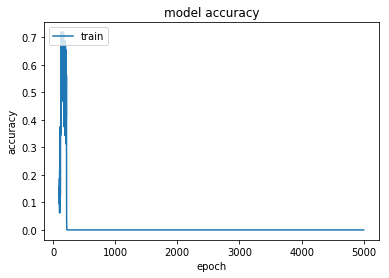

In [22]:
# summarize history for accuracy
plt.plot(metrics.metrics['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

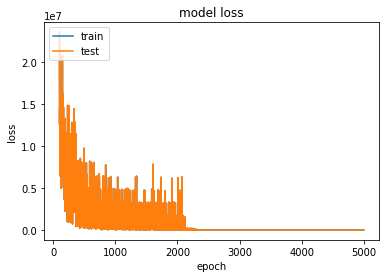

In [24]:
# summarize history for loss
plt.plot(metrics.metrics['loss'])
#plt.plot(metrics.metrics['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('duel_dqn_{}_weights.h5f'.format('stock_bot'), overwrite=True)

In [25]:
model.test(env, nb_episodes=100, visualize=False, callbacks=[metrics])

Testing for 100 episodes ...


TypeError: 'NoneType' object is not subscriptable